In [46]:
import csv
import thesis_tools
import numpy as np
import pandas as pd

from scipy.stats import linregress
from itertools import chain

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import Normalize

import seaborn as sb
blue=sb.xkcd_palette(['windows blue'])[0]
amber=sb.xkcd_palette(['amber'])[0]
% matplotlib inline
plt.style.use('sm')

In [47]:
sheffer_data=pd.read_csv('sheffer_co_h2.csv')
burgh_data=pd.read_csv('burgh_data.csv')

In [49]:
with open('primary_sightlines.csv','rb') as csvfile:
    inp=csv.reader(csvfile)
    primary_sightlines=inp.next()

sl_data=thesis_tools.load_data(primary_sightlines)
all_data=thesis_tools.load_results(sl_data)

/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(15.5,11,u'Integrated')

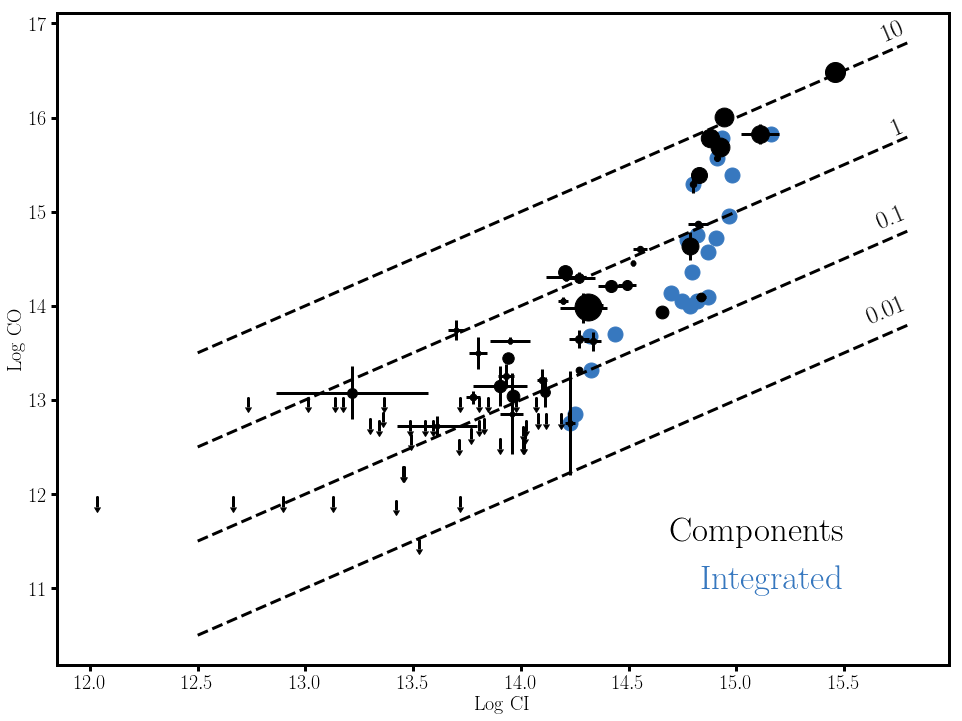

In [51]:
fig=plt.figure(1,figsize=(16,12))
subplt=plt.subplot(111)

cut_data=all_data[(all_data['C']>0)]
for sl,data in cut_data.groupby('Sightline'):
    cs_to_sum=all_data[all_data['Sightline']==sl]
    cs=[np.log10(np.sum([10**row[col] for col in ('C','C*','C**')])) for idx,row in cs_to_sum.iterrows()]
    c_errs=list(chain.from_iterable([list(row) for idx,row in cs_to_sum[['C_err','C*_err','C**_err']].iterrows()]))
    c_sum=np.log10(np.sum([10**n for n in cs]))
    c_sum_err=0.434*np.sqrt(np.sum([10**(2*n) for n in c_errs]))/(10**c_sum)
    
    cos_to_sum=all_data[all_data['Sightline']==sl]
    co_sum=np.log10(np.sum([10**n for n in cos_to_sum['CO']]))
    co_sum_err=0.434*np.sqrt(np.sum([10**(2*n) for n in cos_to_sum['CO_err']]))/(10**(co_sum))
    subplt.plot(c_sum,co_sum,marker='o',color=blue,markersize=15,zorder=-1)
    
    num_c_comps=len(all_data[(all_data['Sightline']==sl)&(all_data['C']>0)])
    for idx,row in data.iterrows():
        c=np.log10(np.sum([10**row[col] for col in ('C','C*','C**')]))
        c_err=0.434*np.sum([10**row[col+'_err'] for col in ('C','C*','C**')])/10**c
        if row['CO']<10:
            subplt.errorbar(c,row['CO_err'],
                            yerr=0.1, uplims=True,color='k',marker='o',markersize=2)
        else:
            co_err=0.434*(10**(row['CO_err']-row['CO']))
            subplt.errorbar(c,row['CO'],xerr=c_err,yerr=co_err,marker='o',color='k',markersize=20*row['f_H2']+5)
        #subplt.text(c, row['CO'], sl+' '+str(row['Velocity']))
        #print '\t',10**(row['CO']-c_tot)
    
    
tx=np.arange(12.5,15.8,0.1)
for rat in (0.01,0.1,1,10):
    ty=np.array([np.log10(rat*(10**x)) for x in tx])
    subplt.plot(tx,ty,'k--')
    subplt.text(tx[-1],ty[-1]-0.04,str(rat),fontsize=25,ha='right',va='bottom',rotation=23)
subplt.set_ylabel('Log CO',fontsize=20)
subplt.set_xlabel('Log CI',fontsize=20)
subplt.tick_params(axis='both', which='major', labelsize=20)

subplt.text(15.5,11.5,'Components',color='k',fontsize=35,horizontalalignment='right')
subplt.text(15.5,11,'Integrated',color=blue,fontsize=35,horizontalalignment='right')

#plt.savefig('/Users/codydirks/Desktop/components_vs_integrated.pdf')

Text(16.1,11.5,u'\\textbf{Mine}')

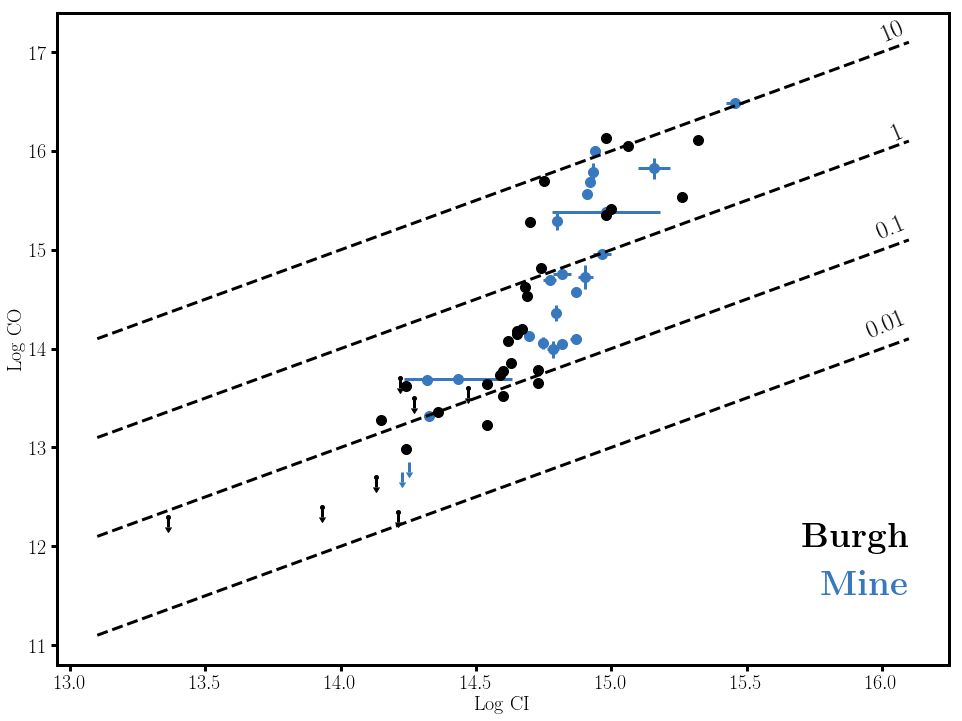

In [54]:
fig=plt.figure(1,figsize=(16,12))
subplt=plt.subplot(111)

cut_data=all_data[(all_data['C']>0)]
for sl,data in cut_data.groupby('Sightline'):
    cs_to_sum=all_data[all_data['Sightline']==sl]
    cs=[np.log10(np.sum([10**row[col] for col in ('C','C*','C**')])) for idx,row in cs_to_sum.iterrows()]
    c_errs=list(chain.from_iterable([list(row) for idx,row in cs_to_sum[['C_err','C*_err','C**_err']].iterrows()]))
    c_sum=np.log10(np.sum([10**n for n in cs]))
    c_sum_err=0.434*np.sqrt(np.sum([10**(2*n) for n in c_errs]))/(10**c_sum)
    if c_sum_err>1:
        c_sum_err=0.2
    
    cos_to_sum=all_data[all_data['Sightline']==sl]
    co_sum=np.log10(np.sum([10**n for n in cos_to_sum['CO']]))
    f=2*(np.sum([10**x for x in cos_to_sum['H_2']]))/(np.sum([10**x for x in cos_to_sum['H_tot']]))
    co_sum_err=0.434*np.sqrt(np.sum([10**(2*n) for n in cos_to_sum['CO_err']]))/(10**(co_sum))
    if co_sum_err>0.2:
        subplt.errorbar(c_sum,co_sum,yerr=0.1,uplims=True,color=blue,markersize=15,zorder=-1)
    else:
        subplt.errorbar(c_sum,co_sum,xerr=c_sum_err,yerr=co_sum_err,marker='o',color=blue,markersize=10,zorder=-1)
    

for idx,row in burgh_data.iterrows():
    #if row['Sightline'] not in all_data['Sightline'].unique():
    # TODO: Add in upper limits
    if row['CO'].startswith('<'):
        co=float(row['CO'][1:])
        cI=float(row['CI'])
        subplt.errorbar(cI,co,yerr=0.1, uplims=True,color='k',marker='o',markersize=4)
    else:
        subplt.plot(float(row['CI']),float(row['CO']),marker='o',color='k',markersize=10)

    
tx=np.arange(13.1,16.1,0.1)
for rat in (0.01,0.1,1,10):
    ty=np.array([np.log10(rat*(10**x)) for x in tx])
    subplt.plot(tx,ty,'k--')
    subplt.text(tx[-1],ty[-1]-0.04,str(rat),fontsize=25,ha='right',va='bottom',rotation=23)
subplt.set_ylabel('Log CO',fontsize=20)
subplt.set_xlabel('Log CI',fontsize=20)
subplt.tick_params(axis='both', which='major', labelsize=20)

subplt.text(16.1,12,'\\textbf{Burgh}',color='k',fontsize=35,ha='right')
subplt.text(16.1,11.5,'\\textbf{Mine}',color=blue,fontsize=35,ha='right')

#plt.savefig('/Users/codydirks/Desktop/burgh_vs_mine.pdf')

In [ ]:
# 12CO/13CO Plots
# Filter results 
nco_min=12
nco_max=17
ncl_min=11 # Below this, Balashev conversion to H2 becomes extremely uncertain
#cut=all_data.loc[(all_data['Cl_I']>ncl_min) & (all_data['13CO']>12)]
cut=all_data.loc[(all_data['12CO/13CO']>0)&(all_data['12CO/13CO']<100)&(all_data['13CO']>13)]

# Sightline | CO | 13CO
sheffer_isotope_data=[('HD22951', 1.83e14,2.31e12),
('HD23180', 6.78e14,9.32e12),
('HD23478', 8.05e14,12.0e12),
('HD24398', 17.9e14,16.5e12),
('HD24534', 158e14,186.0e12),
('HD27778', 123e14,183.0e12),
('HD99872', 4.54e14,5.6e12),
('HD147683', 80.3e14,113e12),
('HD148937', 3.81e14,6.6e12),
('HD177989', 4.4e14,8.35e12),
('HD192035', 13.9e14,27.5e12),
('HD198781', 16.6e14,27.7e12),
('HD203374A', 25.5e14,33.3e12),
('HD203532', 45.6e14,111e12),
('HD206267A', 134e14,322e12),
('HD207198', 31.6e14,66.1e12),
('HD207308', 83.2e14,118e12),
('HD207538', 23.4e14,45.6e12),
('HD208266', 116e14,138e12),
('HD210839', 27.5e14,35.4e12)]


fig=plt.figure(1,figsize=(16,12))
subplt=plt.subplot(111)
cm = plt.cm.get_cmap('viridis')
subplt.scatter(cut['CO'],cut['13CO'],marker='o',color=blue,s=100)

x2=[]
y2=[]
for entry in sheffer_isotope_data:
    if entry[0] not in cut['Sightline'].values:
        x2.append(np.log10(entry[1]))
        y2.append(np.log10(entry[2]))
subplt.scatter(x2,y2,marker='o',color=amber,s=100)

tx=np.arange(14,17,0.5)
ty=np.array([np.log10((10**x)/70) for x in tx])
subplt.plot(tx,ty,'k--')

In [ ]:
fig=plt.figure(1,figsize=(16,12))

subplt=plt.subplot(111)

cut_data=all_data[(all_data['C']>0) & (all_data['CO']>12) & (all_data['Cl']>0)]
for sl,data in cut_data.groupby('Sightline'):
    for idx,row in data.iterrows():
        c=np.log10(np.sum([10**row[col] for col in ('C','C*','C**')]))
        #if row['CO_err']/row['CO']>1:
        #    subplt.errorbar(10**(row['CO']-row['H_2']),10**(row['CO']-c),
        #                    yerr=0.1, uplims=True,color=blue,marker='o',markersize=4)
        #else:
        #    subplt.plot(10**(row['CO']-row['H_2']),10**(row['CO']-c),
        #                marker='o',color=blue,markersize=30*(row['f_H2'])+5,alpha=0.9)
            
    to_sum=all_data[all_data['Sightline']==sl]
    cs=[np.log10(np.sum([10**row[col] for col in ('C','C*','C**')])) for idx,row in to_sum.iterrows()]
    c_tot=np.log10(np.sum([10**n for n in cs]))
    
    co_tot=np.log10(np.sum([10**n for n in to_sum['CO']]))
    
    h2_tot=np.log10(np.sum([10**n for n in to_sum['H_2']]))
    f=2*10**(h2_tot)/np.sum([10**n for n in to_sum['H_tot']])
    print sl, f
    subplt.plot(10**(co_tot-h2_tot),10**(co_tot-c_tot),marker='o',color=blue,markersize=30*f+5)

    
for idx,row in burgh_data.iterrows():
    h2=float(row['H2'])
    c=float(row['CI'])
    f=float(row['f'])
    if row['CO'].startswith('<'):
        co=float(row['CO'][1:])
        subplt.errorbar(10**(co-h2),10**(co-c),yerr=0.1*(10**(co-c)),xerr=0.1*(10**(co-h2)),
                        xuplims=True,uplims=True,color=amber)
    else:
        co=float(row['CO'])
        subplt.plot(10**(co-h2),10**(co-c),marker='o',color=amber,markersize=30*f+5,alpha=0.9)

subplt.set_yscale('log')
subplt.set_xscale('log')
subplt.set_ylim(0.007,100)
subplt.set_xlim(1e-8,1e-4)
subplt.axvline(1e-6,0,1,color='k',linestyle='--')
subplt.axhline(1.0,0,1,color='k',linestyle='--')

subplt.text(0.02,0.86,'\\textbf{Burgh}',transform=subplt.transAxes,color=amber,fontsize=40,ha='left')
subplt.text(0.02,0.92,'\\textbf{Mine}',transform=subplt.transAxes,color=blue,fontsize=40,ha='left')

subplt.text(0.92,0.27,'\underline{f$_{H_2}$}',transform=subplt.transAxes,fontsize=50,ha='center',va='center')
subplt.plot(0.96,0.05,marker='o',color='k',markersize=30*0.1+5,alpha=0.9,transform=subplt.transAxes)
subplt.plot(0.96,0.12,marker='o',color='k',markersize=30*0.5+5,alpha=0.9,transform=subplt.transAxes)
subplt.plot(0.96,0.19,marker='o',color='k',markersize=30*1.0+5,alpha=0.9,transform=subplt.transAxes)
subplt.text(0.92,0.045,'0.1',transform=subplt.transAxes,color='k',fontsize=40,ha='right',va='center')
subplt.text(0.92,0.115,'0.5',transform=subplt.transAxes,color='k',fontsize=40,ha='right',va='center')
subplt.text(0.92,0.185,'1.0',transform=subplt.transAxes,color='k',fontsize=40,ha='right',va='center')

subplt.set_xlabel('CO/H$_2$',fontsize=25)
subplt.set_ylabel('CO/C',fontsize=25)
subplt.tick_params(axis='both', which='major', labelsize=20)


#plt.savefig('/Users/codydirks/Desktop/co_c_h2_ratios_integrated.pdf')

Text(0.5,0,u'Molecular Fraction')

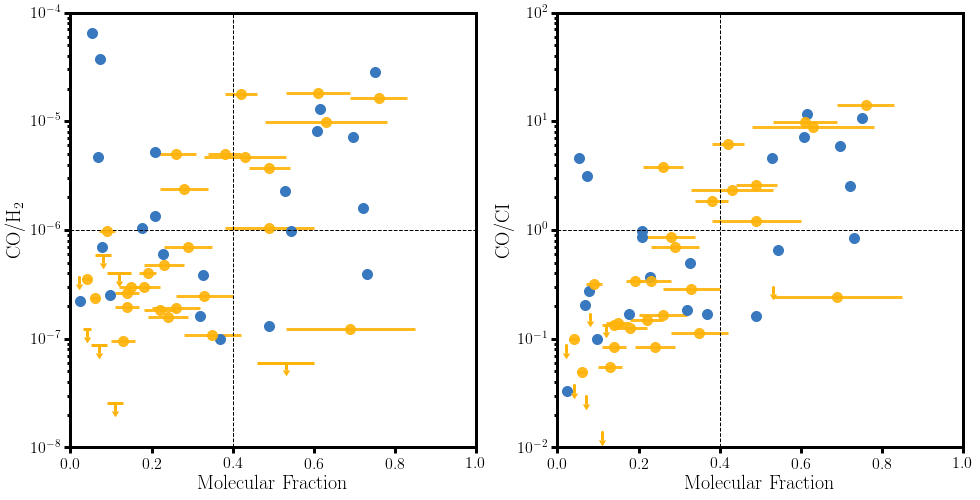

In [56]:
fig,(subplt1,subplt2)=plt.subplots(ncols=2,sharex=True,figsize=(16,8))

cut_data=all_data[(all_data['C']>0) & (all_data['CO']>12) & (all_data['Cl']>0)]
for sl,data in cut_data.groupby('Sightline'):
    for idx,row in data.iterrows():
        c=np.log10(np.sum([10**row[col] for col in ('C','C*','C**')]))
        if row['CO_err']/row['CO']>1:
            subplt.errorbar(10**(row['CO']-row['H_2']),10**(row['CO']-c),
                            yerr=0.1, uplims=True,color=blue,marker='o',markersize=4)
        else:
            subplt.plot(10**(row['CO']-row['H_2']),10**(row['CO']-c),
                        marker='o',color=blue,markersize=30*(row['f_H2'])+5,alpha=0.9)
            
    to_sum=all_data[all_data['Sightline']==sl]
    cs=[np.log10(np.sum([10**row[col] for col in ('C','C*','C**')])) for idx,row in to_sum.iterrows()]
    c_tot=np.log10(np.sum([10**n for n in cs]))
    co_tot=np.log10(np.sum([10**n for n in to_sum['CO']]))
    h2_tot=np.log10(np.sum([10**n for n in to_sum['H_2']]))
    f=2*10**(h2_tot)/np.sum([10**n for n in to_sum['H_tot']])
    
    subplt1.plot(f,10**(co_tot-h2_tot),'ko',marker='o',color=blue,markersize=10)
    subplt2.plot(f,10**(co_tot-c_tot),'ko',marker='o',color=blue,markersize=10)

    
for idx,row in burgh_data.iterrows():
    h2=float(row['H2'])
    c=float(row['CI'])
    f=float(row['f'])
    if row['CO'].startswith('<'):
        co=float(row['CO'][1:])
        subplt1.errorbar(f,10**(co-h2),yerr=0.15*(10**(co-h2)),xerr=row['f_err'],
                        uplims=True,color=amber,marker='o',markersize=2)
        subplt2.errorbar(f,10**(co-c),yerr=0.15*(10**(co-c)),
                        uplims=True,color=amber,marker='o',markersize=2)
    else:
        co=float(row['CO'])
        subplt1.errorbar(f,10**(co-h2),xerr=row['f_err'],marker='o',color=amber,markersize=10,alpha=0.9)
        subplt2.errorbar(f,10**(co-c),xerr=row['f_err'],marker='o',color=amber,markersize=10,alpha=0.9)

        
subplt1.axvline(0.4,linestyle='--',lw=1)
subplt2.axvline(0.4,linestyle='--',lw=1)
subplt1.axhline(1e-6,linestyle='--',lw=1)
subplt2.axhline(1,linestyle='--',lw=1)
subplt1.set_yscale('log')
subplt2.set_yscale('log')
subplt1.set_xlim(0,1)
subplt1.set_ylim(1e-8,1e-4)
subplt2.set_ylim(0.01,100)
subplt1.set_ylabel('CO/H$_2$')
subplt2.set_ylabel('CO/CI')
subplt1.set_xlabel('Molecular Fraction')
subplt2.set_xlabel('Molecular Fraction')

Text(0.95,0.05,u'Integrated')

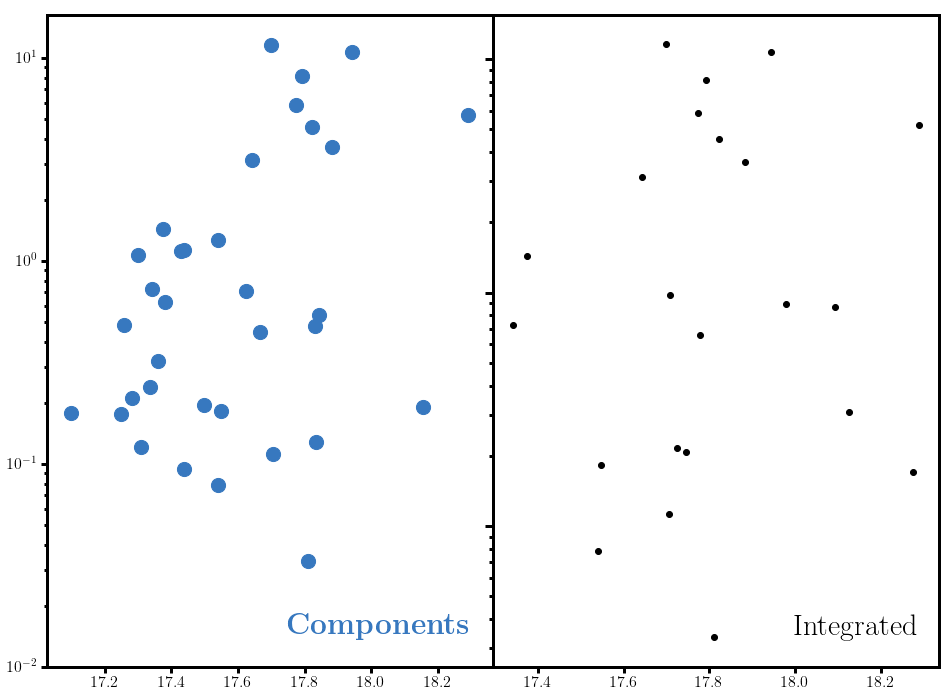

In [147]:
fig=plt.figure(1,figsize=(16,12))
subplt1=plt.subplot(121)
subplt2=plt.subplot(122)

cut_data=all_data[(all_data['C']>0) & (all_data['CO']>0)&(all_data['O']>16)]
for sl,data in cut_data.groupby('Sightline'):
    cs=data[['C','C*','C**']]
    c_tot=np.log10(np.sum(10**data[['C','C*','C**']].values))
    co_tot=np.log10(np.sum([10**n for n in data['CO']]))
    o_tot=np.log10(np.sum([10**n for n in data['O']]))
    subplt2.plot(o_tot,10**(co_tot-c_tot),'ko',zorder=2)
    
    cs=np.log10((10**data[['C','C*','C**']]).sum(axis=1))
    subplt1.scatter(data['O'],10**(data['CO']-cs),marker='o',color=blue,s=200,zorder=1)
    
subplt1.set_yscale('log')
subplt2.set_yscale('log')
plt.subplots_adjust(wspace=0)
subplt2.set_yticklabels([])
subplt2.tick_params('y',which='major',length=8)
subplt2.tick_params('y',which='minor',length=4)

subplt1.text(0.95,0.05,'\\textbf{Components}',fontsize=30,transform=subplt1.transAxes,ha='right',color=blue)
subplt2.text(0.95,0.05,'Integrated',fontsize=30,transform=subplt2.transAxes,ha='right')

In [107]:
cut_data=all_data[all_data['Sightline']=='HD147683']
np.log10((10**cut_data[['C','C*','C**']]).sum(axis=1).sum())
np.log10((10**cut_data[['C','C*','C**']]).sum(axis=1))

46    14.875936
47    14.008405
dtype: float64